# Active Inference Design Agent (research)

In [1]:
using JLD
using Distributions
using LinearAlgebra
using Random 
using WAV
using Plots
using ImageCore
using AIDA
using Parameters
import ProgressMeter

In this demo we will work with two different contexts (environemtns): babble and train noises. 

You can think of a user who keeps wandering around a train station: sometimes train arrives and he/she hears the train noises. When there is no train arriving to the platform, the user hears the babble from people waiting for the train.
When someone starts talking to the user he would (maybe) prefer to damp the environmental noise and focus only on the speaker.

Another possible scenario you can think of is the user who steps out of the train and goes to the bar, where people produce babble noise :D 

## Let's obtain priors for the environment

In [135]:
training_dir = "../sound/AIDA/training/"
contexts = ["babble", "train"]
input_SNRs = ["0dB", "5dB", "10dB"]
input_fn = "sp01";

To make our model identifiabile, we would like to obtain priors for the environmental noises. To do this, we use Voice-Activity-Detection (VAD) to find the silent segments (with no speech). When those frames are identified, we fit them to AR model of order 2 to learn the parameters of AR.

Surely, you can obtain the priors based on different logic. (to discuss (1) it doesn't have to be AR, (2) it doesn't have to be VAD)

In [139]:
snr_id = 2
wavs = map(x -> wavread("$(training_dir)$(x)/$(input_SNRs[snr_id])/$(input_fn)_$(x)_sn$(input_SNRs[snr_id][1:end-2]).wav"), contexts)
signals = first.(wavs)
fs = getindex.(wavs, 2)[1]
seg_signals = get_frames.(signals, fs);
totsegs = size.(seg_signals, 1);

### VAD block

In [138]:
@unpack cmx, cvx, cmη, cvη, cτ = JLD.load("../src/memory/context_babble_$(input_SNRs[snr_id]).jld")
# prior for babble noise
bblmη = mean(cmη, dims=1)
bblvη = mean(cvη, dims=1)[1, :, :]
bblτ  = (cτ[end][1], cτ[end][2])

LoadError: ArgumentError: No file exists at given path: ../src/memory/context_babble_5dB.jld

In [123]:
@unpack cmx, cvx, cmη, cvη, cτ = JLD.load("../src/memory/context_train_$(input_SNRs[snr_id]).jld")
# prior for train noise
trmη = mean(cmη, dims=1)
trvη = mean(cvη, dims=1)[1, :, :]
trτ  = (cτ[end][1], cτ[end][2])

(41.0, 0.005009500491876784)

You can skip this entire block if you used priors from the above cell.

In [140]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
vads = map(_ -> [], contexts)
ar_order = 10
vmp_iter = 50
for c_num in 1:length(contexts)
    ProgressMeter.@showprogress for segnum in 1:totsegs[c_num]
        vad = model_selection(seg_signals[c_num][segnum, :], 
                              lar_inference, inference_gaussian, 
                              vmp_iter=vmp_iter, 
                              priors_m1=Dict(:aτ => 1e-4, :bτ => 1e-4, :aγ => 1e-4, :bγ => 1e-4, :order => ar_order), 
                              priors_m2=Dict(:aτ => 1e-4, :bτ => 1e-4))
        push!(vads[c_num], vad)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:47
Progress: 100%|█████████████████████████████████████████| Time: 0:10:42


In [142]:
for c_num in 1:length(contexts)
    context_seg = seg_signals[c_num]
    totseg = totsegs[c_num]
    # find voiced and silent frames
    vsegs = findall(isequal(1), vads[c_num]) # voiced frames
    ssegs = findall(isequal(0), vads[c_num]); # silent frames
    cmx, cvx, cmη, cvη, cτ = lar_batch_learning(hcat([context_seg[sseg, :] for sseg in ssegs]...)', 10, Dict(:τ => 1e12, :order => 2));
    println("Context-$(contexts[c_num]) $(mean(cmη, dims=1)), $(mean(cvη, dims=1)[1, :, :]), , $((cτ[end][1], cτ[end][2]))")
    JLD.save("../src/memory/context_$(contexts[c_num])_$(input_SNRs[snr_id]).jld", "cmx", cmx, "cvx", cvx, "cmη", cmη, "cvη", cvη, "cτ", cτ, "context", contexts[c_num])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


Context-babble [1.0600545153862335 -0.43138050626710506], [0.008327069374210159 -0.0051609400778652665; -0.0051609400778652665 0.006396143290291695], , (41.0, 0.0007511129380456242)
Context-train [0.417160812125732 -0.172647240637262], [0.009531448941821605 -0.0024320127061295592; -0.0024320127061295592 0.004585262389700494], , (41.0, 0.010635880194034013)


## Source seperation
When priors for the contexts are indentified, we can run noise reduction algorithm based on coupled AR: AR_speech + AR_envrionment = output. This algorithm seperates speech (**z**) and noise (**x**)

We will split our dataset into training and test set. We use signals from training set to learn the mapping function between the gains proposed by agent and aprraisals provided by user. Bare in mind that this split is not necessary and in theory we can get along without it.

In [143]:
# informative
# map "static" priors to the corresponding matrices with equal element
bblmη_arr, bblvη_arr, bblτ_arr = prior_to_priors(bblmη, bblvη, bblτ, totsegs[1], 2);
trmη_arr, trvη_arr, trτ_arr = prior_to_priors(trmη, trvη, trτ, totsegs[2], 2);

In [147]:
# weakly informative
bblmη_arr, bblvη_arr, bblτ_arr = prior_to_priors(zeros(2), diageye(2), bblτ, totsegs[1], 2);
trmη_arr, trvη_arr, trτ_arr = prior_to_priors(zeros(2), diageye(2), trτ, totsegs[2], 2);

In [145]:
db = "5dB"
training_files = vcat(get_files.(map(x -> "../sound/AIDA/training/$(x)/$(db)", contexts))...);

In [151]:
training_files

42-element Vector{Any}:
 "../sound/AIDA/training/babble/5dB/.DS_Store"
 "../sound/AIDA/training/babble/5dB/sp01_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp02_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp03_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp04_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp05_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp06_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp07_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp08_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp09_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp10_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp11_babble_sn5.wav"
 "../sound/AIDA/training/babble/5dB/sp12_babble_sn5.wav"
 ⋮
 "../sound/AIDA/training/train/5dB/sp09_train_sn5.wav"
 "../sound/AIDA/training/train/5dB/sp10_train_sn5.wav"
 "../sound/AIDA/training/train/5dB/sp11_train_sn5.wav"
 "../sound/AIDA/training/train/5dB/sp12_train_sn5.wav"
 "../sound/AIDA/traini

In [146]:
# Check for how the data is organized
training_file = training_files[8]
println(training_file)
speech, fs = WAV.wavread(training_file)
speech_seg = get_frames(speech, fs)

../sound/AIDA/training/babble/5dB/sp07_babble_sn5.wav


336×80 Matrix{Float64}:
 -0.0200812   -0.0332347   -0.0396741    …  -0.00769066    0.0211798
  0.0117496    0.0138249    0.0348216        0.00311289   -0.0110782
 -0.0184942   -0.0365001   -0.0302438        0.036256      0.0307627
 -0.0334178   -0.0484024   -0.0529496       -0.0549333    -0.0254524
 -0.0281075   -0.0110172   -0.0184027       -0.00726341    6.1037e-5
 -0.02472     -0.026368    -0.00781274   …   0.00918607    0.0120243
 -0.0156865   -0.0158391   -0.0189215        0.0130314    -0.00231941
 -0.0273141   -0.0124821    0.00958281      -0.0036317     0.0184332
 -0.023133    -0.041261    -0.0237129       -0.0441603    -0.0260933
 -0.007416    -0.0413831   -0.0381787        0.0229804     0.00317392
 -0.00558489   0.00469985   0.00799585   …   0.00738548    0.0126652
 -0.0161748   -0.00790429   0.012299        -0.0110782    -0.00589007
  0.0152898    0.0298776    0.0303049        0.00521867    0.0195318
  ⋮                                      ⋱                
  0.0207221    0.

At this stage we run our inference algorithm to seperate **z** and **x**. We write the output into *.jld* files.

You don't need to run this snippet if you haven't changed the default parameters of HA_algorithm and priors (just see *sound/AIDA/separated_jld/training/*)

In [150]:
# r for recovered
ar_speech = 10
ar_env = 2
vmp_iter = 30

for training_file in training_files
    if !occursin(".wav", training_file) continue end
    
    if occursin("/$(contexts[1])/", training_file)
        priors_eta = (bblmη_arr, bblvη_arr)
        priors_tau = bblτ_arr
    elseif occursin("/$(contexts[2])/", training_file)
        priors_eta = (trmη_arr, trvη_arr)
        priors_tau = trτ_arr
    else
        continue
    end
    
    speech, fs = WAV.wavread(training_file)
    speech_seg = get_frames(speech, fs)
    
    # make sure that 1D of priors and speech_seg are equal
    if size(priors_eta, 1) != size(speech_seg, 1)
        totseg = size(speech_seg, 1)
        priors_eta_m, priors_eta_v, priors_tau = prior_to_priors(priors_eta[1][1, :]', priors_eta[2][1, :, :], priors_tau[1], totseg, ar_env)
        priors_eta = priors_eta_m, priors_eta_v
    end
    
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe = batch_coupled_learning(speech_seg, priors_eta, priors_tau, ar_speech, ar_env, vmp_iter);
    
    JLD.save("../sound/AIDA/separated_jld/training/"*training_file[findfirst("sp", training_file)[1]:end][1:end-3]*"jld",
         "rmz", rmz, "rvz", rvz, "rmθ", rmθ, "rvθ", rvθ, "rγ", rγ, 
         "rmx", rmx, "rvx", rvx, "rmη", rmη, "rvη", rvη, "rτ", rτ,
         "fe", fe, "filename", training_file)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:42
Progress: 100%|█████████████████████████████████████████| Time: 0:06:18
Progress: 100%|█████████████████████████████████████████| Time: 0:06:20
Progress: 100%|█████████████████████████████████████████| Time: 0:06:18
Progress: 100%|█████████████████████████████████████████| Time: 0:06:26
Progress: 100%|█████████████████████████████████████████| Time: 0:07:47
Progress: 100%|█████████████████████████████████████████| Time: 0:06:14
Progress: 100%|█████████████████████████████████████████| Time: 0:07:10
Progress: 100%|█████████████████████████████████████████| Time: 0:07:13
Progress: 100%|█████████████████████████████████████████| Time: 0:06:24
Progress: 100%|█████████████████████████████████████████| Time: 0:07:00
Progress: 100%|█████████████████████████████████████████| Time: 0:06:36
Progress: 100%|█████████████████████████████████████████| Time: 0:06:24
Progress: 100%|█████████████████████████████████████████| Time: 

### Preference learning stage

#### Generate outputs of HA from JLD files

In [149]:
# obtain saved jld files containing inference result
training_jlds = get_files("../sound/AIDA/separated_jld/training/");

In [104]:
# initialize gains that agent randomly assigns to the outputs of HA
agent_gains = [[2.0, 1.0], [1.0, 0.0], [0.5, 0.5], [0.9, 0.3], [2.5, 1.0], [0.9, 0.1], [0.7, 0.2], [0.2, 0.7], [2.0, 0.0]];

In [110]:
# this snippet generates new ha outputs
for training_jld in training_jlds
    # read file
    d = JLD.load(training_jld)
    filename = d["filename"]
    # extract speech and noise
    rz, rx = get_signal(d["rmz"], fs), get_signal(d["rmx"], fs)
    # pick weights 
    whgs = rand(agent_gains) # can be changed to a smarter function
    # create output
    ha_out = whgs[1] .* rz + whgs[2] .* rx
    # write wav file
    WAV.wavwrite(ha_out, fs, "../sound/AIDA/preference_learning/ha_out_$(whgs[1])_$(whgs[2])_"*filename[findfirst("sp", filename)[1]:end])
end

#### Create pairs (gains, context) <-> appraisals

In [107]:
# Recorded gains and appraisals 
# If you want to generate new pairs, please procceed with listening
preferences = JLD.load("../src/memory/preferences.jld")
@unpack gains, appraisals, contexts = preferences

Dict{String, Any} with 3 entries:
  "gains"      => [[2.0, 1.0], [2.0, 1.0], [2.5, 1.0], [1.0, 0.0], [0.5, 0.5], …
  "appraisals" => [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7  …  0.7, 0.…
  "contexts"   => [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0  …  1.0, 0.…

#### Listening

User gets to listen new audio samples with proposed gains. After each listening he/she evaluates the performance of HA output by binary feedback.

In [116]:
prl_files = get_files("../sound/AIDA/preference_learning/");

# This snippet creates interactive loop where user can like/dislike hearing aid output
nnum = 8 # prefix for gains

appraisals, gains, contexts = [], [], []
shuffle!(prl_files)
println("Evaluate the HA output from 0.0 (very bad) to 1.0 (excellent)")
flush(stdout)
for prl_file in prl_files
    
    if !occursin("wav", prl_file)
        continue
    end
    WAV.wavplay(prl_file)
    
    # extract gains routine
    pref_id = findfirst("out_", prl_file)[end]
    gains_str = prl_file[pref_id+1:pref_id+nnum-1]
    push!(gains, parse.(Float64, split(gains_str, "_")))
    println(gains[end])
    # extract context routine
    push!(contexts, occursin("babble", prl_file) ? 1.0 : 2.0)
    
    println("How's HA output? (r to repeat)")
    appraisal = -1
    while !(0.0 <= appraisal <= 1.0)
        flush(stdout)
        appraisal = readline()
        if appraisal == "r"
            WAV.wavplay(prl_file)
            appraisal = -1
            continue
        end
        try 
            appraisal = parse(Float64, appraisal)
        catch error
            println(error)
            appraisal = -1
            continue
        end
    end
    push!(appraisals, appraisal)
    
end
JLD.save("../src/memory/preferences.jld", "appraisals", appraisals, "gains", gains, "contexts", contexts)

Evaluate the HA output from 0.0 (very bad) to 1.0 (excellent)
[2.0, 1.0]
How's HA output? (r to repeat)


stdin>  r
stdin>  0.5


LoadError: InterruptException:

In [54]:
function f(params)
    fe = inference_flow_classifier(Float64.(data_y), [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

In [56]:
context = 1.0 #babble
# context = 2.0 #train
data_x, data_y = get_learning_data(preferences, context)

([2.039163646439623 0.961518323989664; 2.0162345477630517 0.9880893495648702; … ; 2.4936673408293486 0.998753713265008; 0.9819225690131673 -0.050998745463014625], [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7  …  0.7, 0.4, 0.65, 0.25, 0.7, 0.0, 0.4, 0.69, 0.7, 0.8])

In [58]:
rng = MersenneTwister(1)

f(randn(rng, 12))

3230.795323208903

In [59]:
using Optim

data_x, data_y = get_learning_data(preferences, 1.0)
res_babble = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-12), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     3.919003e+03     1.412721e+03
 * time: 0.019231081008911133
     1     6.520406e+02     3.857015e+02
 * time: 1.825782060623169
     2     3.089202e+02     3.831069e+02
 * time: 1.9386329650878906
     3     1.354302e+02     2.064472e+02
 * time: 2.158759117126465
     4     1.039910e+02     6.893870e+01
 * time: 2.2058980464935303
     5     9.473020e+01     1.638985e+02
 * time: 2.2519490718841553
     6     8.775167e+01     5.070830e+01
 * time: 2.297697067260742
     7     8.593073e+01     7.443232e+01
 * time: 2.423509120941162
     8     8.007225e+01     2.904188e+01
 * time: 2.4908180236816406
     9     7.893140e+01     2.643606e+01
 * time: 2.5341551303863525
    10     7.890095e+01     5.915723e+00
 * time: 2.61867618560791
    11     7.838249e+01     3.032769e+01
 * time: 2.8194169998168945
    12     7.786692e+01     3.199135e+01
 * time: 2.8636460304260254
    13     7.713336e+01     2.735237e+01
 * time: 2.98826217651367

In [81]:
data_x, data_y = get_learning_data(preferences, 0.0)
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-12), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     3.190653e+03     1.805653e+03
 * time: 5.793571472167969e-5
     1     1.964070e+03     1.320546e+03
 * time: 0.4000129699707031
     2     5.493925e+02     5.767917e+02
 * time: 0.46487998962402344
     3     1.287232e+02     2.339705e+02
 * time: 0.5077340602874756
     4     1.079817e+02     3.512642e+01
 * time: 0.6267571449279785
     5     1.037896e+02     7.165593e+01
 * time: 0.7569370269775391
     6     9.924797e+01     1.072937e+02
 * time: 0.8238379955291748
     7     9.408263e+01     7.289565e+01
 * time: 0.8906729221343994
     8     9.122225e+01     3.940401e+01
 * time: 0.9351279735565186
     9     8.717060e+01     3.621830e+01
 * time: 1.0272190570831299
    10     8.592878e+01     1.352392e+01
 * time: 1.0948669910430908
    11     8.557257e+01     1.295215e+01
 * time: 1.187272071838379
    12     8.461829e+01     1.391789e+01
 * time: 1.2556989192962646
    13     8.437807e+01     1.318834e+01
 * time: 1.34746313

In [61]:
dat_to_col(data) = map(x -> x == 1 ? "red" : "blue", Int64.(round.(data)))

dat_to_col (generic function with 1 method)

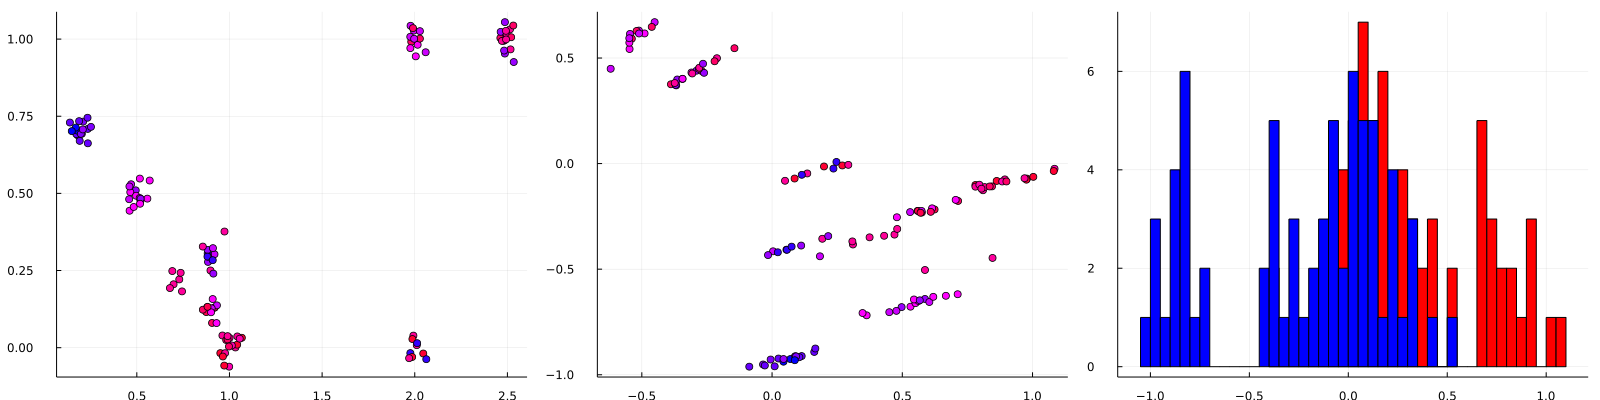

In [82]:
est_params = Optim.minimizer(res_train)
cmap = colorsigned(color("blue"), color("magenta"), color("red")) ∘ scalesigned(0, 0.5, 1.0)
colors = cmap.(data_y)
inferred_model = deepcopy(compile(model, est_params))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .>= 0.5], trans_data_x_2[data_y .<= 0.5]]
plt1 = scatter(data_x[:,1], data_x[:,2], color=colors)
plt2 = scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], color=colors)
hist = histogram(trans_data_x_2_split; stacked=true, bins=60,  fillcolor=["red" "blue"], label = ["Positive" "Negative"], legend=:topleft)
plot(plt1, plt2, hist, size=(1600, 400), legend=false, layout=(1, 3))

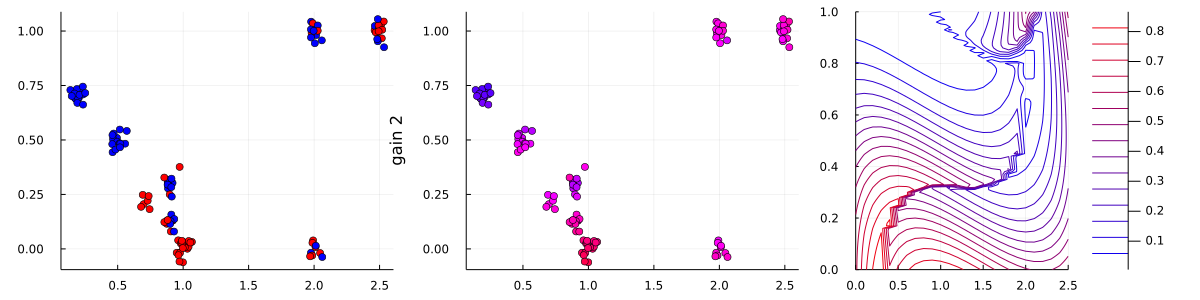

In [83]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:3, 0:0.01:1))))
im1 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=dat_to_col(data_y))
im2 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=cmap.(normcdf.(trans_data_x_2)))
im3 = contour(0.0:0.1:2.5, 0.0:0.01:1, (x, y) -> normcdf(dot([1, 1], forward(inferred_model, [x, y]))), color=["blue", "red"])
plot(im1, im2, im3, legend=false, layout=(1, 3), size=(1200, 300))

## Planning
Few things must be said about the planning stage. 
First of all, the idea of planning is a reverse problem to prefernce learning. 
Given the parameters of neural network, the goal prior for the appraisal (1.0) and an informative prior for the future context (we have an idea of how the environment evolves), we want to infer the most suitable gains.
The evolution of the context will be based on HMM model, where the observations are 

For illustration purposes, we will first run the inference algorithm to obtain **z** and **x**. Secondly, we run our agent that proposes gains.

In [88]:
# test
mgs, covgs = repeat([0.5], 2), diagm(ones(2))
fe, gains = inference_flow_planner(mgs, covgs, 1.0, est_params)

(Rocket.KeepActor{Real}(Real[3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705  …  3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705, 3.68613738717705]), Marginal(MvNormalWeightedMeanPrecision(
xi: [18.052626286880166, 12.485373541907691]
Λ: [5.212839240988446 2.876632314162234; 2.876632314162234 2.964236705348625]
)
))

In [89]:
mean(gains)

2-element Vector{Float64}:
 2.4517545326316315
 1.8327069552655333

In [90]:
test_files = get_files("../sound/AIDA/test/");

In [ ]:
# obtain HA output for test set (data for acting)
# r for recovered
ar_speech = 10
ar_env = 2
vmp_iter = 10

# r for recovered
for test_file in test_files
    if !occursin(".wav", test_file)
        continue
    end
    
    speech, fs = WAV.wavread(test_file)
    speech_seg = get_frames(speech, fs)
    
    # choose priors
    # TODO: infer context
    if occursin("/babble/", test_file)
        priors_eta = (bblmη_arr, bblvη_arr)
        priors_tau = bblτ_arr
    elseif occursin("/train/", test_file)
        priors_eta = (trmη_arr, trvη_arr)
        priors_tau = trτ_arr
    else
        continue
    end
    println(test_file)
    
    # make sure that 1D of priors and speech_seg are equal
    if size(priors_eta, 1) != size(speech_seg, 1)
        totseg = size(speech_seg, 1)
        priors_eta_m, priors_eta_v, priors_tau = prior_to_priors(priors_eta[1][1, :]', priors_eta[2][1, :, :], priors_tau[1], totseg, ar_env)
        priors_eta = priors_eta_m, priors_eta_v
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo = batch_coupled_learning(speech_seg, priors_eta, priors_tau, ar_speech, ar_env, vmp_iter);
    
    JLD.save("sound/AIDA/separated_jld/test/"*test_file[findfirst("sp", test_file)[1]:end][1:end-3]*"jld",
         "rmz", rmz, "rvz", rvz, "rmθ", rmθ, "rvθ", rvθ, "rγ", rγ, 
         "rmx", rmx, "rvx", rvx, "rmη", rmη, "rvη", rvη, "rτ", rτ,
         "fe", fe, "rmo", rmo, "filename", test_file,
         "audio", speech)
end

In [73]:
test_jlds = get_files("../sound/AIDA/separated_jld/test/");

In [74]:
active_dict = deepcopy(preferences)

Dict{String, Any} with 3 entries:
  "gains"      => [[2.0, 1.0], [2.0, 1.0], [2.5, 1.0], [1.0, 0.0], [0.5, 0.5], …
  "appraisals" => [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7  …  0.7, 0.…
  "contexts"   => [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0  …  1.0, 0.…

In [ ]:
# Here agent plans and learns
gs = [0.5, 0.5]
covgs = diageye(2)
context = 0.5
for test_jld in test_jlds
    d = JLD.load(test_jld)
    rmz, rmx = d["rmz"], d["rmx"]
    filename = d["filename"]
    # TODO: context inference
    if occursin("/babble/", filename)
        context = 1.0
        params = Optim.minimizer(res_babble)
        fe, gains = inference_flow_planner(gs, covgs, 1.0, params)
    elseif occursin("/train/", filename)
        context = 0.0
        params = Optim.minimizer(res_train)
        fe, gains = inference_flow_planner(gs, covgs, 1.0, params)
    else
        continue
    end
    rz, rx = get_signal(rmz, fs), get_signal(rmx, fs)
    # TODO change to the output of flow_nn
    gs = mean(gains)
    ha_out = gs[1] .* rz + gs[2] .* rx
    
    full_name = "../sound/AIDA/planning/ha_out_$(gs[1])_$(gs[2])_"*filename[findfirst("sp", filename)[1]:end]
    WAV.wavwrite(ha_out, fs, full_name)
    WAV.wavplay(full_name)
    println("How's HA output 0..1 ?")
    appraisal = readline()
    
    # we can learn here as well. If the user provides a feedback to each proposal, we can feed this information back to our learning function.
    push!(active_dict["appraisals"], parse(Float64, appraisal))
    push!(active_dict["gains"], gs)
    push!(active_dict["contexts"], context)
end

In [ ]:
data_x, data_y = get_learning_data(active_dict, 0.0)
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = false, show_trace = true, f_tol=1e-10), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     1.209474e+04     6.701012e+03
 * time: 0.00010085105895996094
     1     3.251034e+03     2.362342e+03
 * time: 0.32674694061279297
     2     4.804030e+02     4.138629e+02
 * time: 0.47789788246154785
     3     2.772470e+02     1.262527e+02
 * time: 0.6343679428100586
     4     2.525020e+02     1.375445e+02
 * time: 0.7901079654693604
     5     2.398343e+02     1.007449e+02
 * time: 0.9000217914581299
     6     2.303162e+02     6.324120e+01
 * time: 1.067605972290039
     7     2.241098e+02     1.563470e+02
 * time: 1.227712869644165
     8     1.785655e+02     1.891067e+02
 * time: 1.433762788772583
     9     1.742830e+02     1.427989e+02
 * time: 1.5871319770812988
    10     1.641674e+02     1.360540e+02
 * time: 1.7534849643707275
    11     1.611405e+02     6.436318e+01
 * time: 1.9063308238983154
    12     1.593350e+02     3.289795e+01
 * time: 2.1091527938842773
    13     1.570431e+02     4.289117e+01
 * time: 2.4023489

In [ ]:
data_x, data_y = get_learning_data(active_dict, 1.0)
res_babble = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = false, show_trace = true, f_tol=1e-10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.896678e+04     8.453586e+03
 * time: 0.00014781951904296875
     1     3.031413e+03     8.696211e+03
 * time: 0.3738739490509033
     2     1.408799e+03     2.492577e+03
 * time: 0.6177668571472168
     3     5.303161e+02     8.336671e+02
 * time: 0.8022058010101318
     4     4.764814e+02     3.304571e+02
 * time: 0.9433548450469971
     5     3.480734e+02     3.894615e+02
 * time: 1.1286427974700928
     6     2.893697e+02     4.497519e+02
 * time: 1.2758409976959229
     7     2.449295e+02     1.305892e+02
 * time: 1.3842239379882812
     8     2.380654e+02     4.238580e+02
 * time: 1.4889748096466064
     9     2.165718e+02     2.677151e+02
 * time: 1.6860268115997314
    10     1.933184e+02     5.339142e+01
 * time: 1.8787009716033936
    11     1.878039e+02     8.013747e+01
 * time: 2.0669097900390625
    12     1.780145e+02     1.062218e+02
 * time: 2.22525691986084
    13     1.747833e+02     1.138836e+02
 * time: 2.42100477

 * Status: success

 * Candidate solution
    Final objective value:     1.195547e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-10
    |g(x)|                 = 2.05e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    63
    f(x) calls:    448
    ∇f(x) calls:   448


In [ ]:
using StatsFuns: normcdf
data_x, data_y = get_learning_data(active_dict, 0.0)
params = Optim.minimizer(res_train)
inferred_model = deepcopy(compile(model, params))
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:3, 0:0.01:1))))
im1 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=dat_to_col(data_y))
im2 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=cmap.(normcdf.(trans_data_x_2)))
im3 = contour(0.0:0.1:2.5, 0.0:0.01:2.5, (x, y) -> normcdf(dot([1, 1], forward(inferred_model, [x, y]))), color=["blue", "red"])
plot(im1, im2, im3, legend=false, layout=(1, 3), size=(1200, 300))